### Loading the data

In [1]:
import kagglehub

path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
dataframes = {}
for dataset in os.listdir(path): # list all files in the directory
    print(dataset)
    dataframes[dataset] = pd.read_csv(os.path.join(path, dataset)) # load the dataset into a pandas dataframe

rating.csv
tag.csv
genome_scores.csv
genome_tags.csv
link.csv
movie.csv


In [3]:
for dataset in dataframes:
    print(dataset)
    print(f"Shape: {dataframes[dataset].shape}")
    print(dataframes[dataset].head(3))
    print()

rating.csv
Shape: (20000263, 4)
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39

tag.csv
Shape: (465564, 4)
   userId  movieId          tag            timestamp
0      18     4141  Mark Waters  2009-04-24 18:19:40
1      65      208    dark hero  2013-05-10 01:41:18
2      65      353    dark hero  2013-05-10 01:41:19

genome_scores.csv
Shape: (11709768, 3)
   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775

genome_tags.csv
Shape: (1128, 2)
   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century

link.csv
Shape: (27278, 3)
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0

movie.csv
Shape: (27278, 3)
   movieId                    title  \
0        1         Toy Story (1995)   
1      

In [4]:
tags_df = dataframes['tag.csv']
movies_df = dataframes['movie.csv']
ratings_df = dataframes['rating.csv']
links_df = dataframes['link.csv']
genome_scores_df = dataframes['genome_scores.csv']
genome_tags_df = dataframes['genome_tags.csv']


In [5]:
print(movies_df.info()); print(f"Are the movie id's unique? {movies_df.movieId.nunique() == movies_df.shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None
Are the movie id's unique? True


## 2. Grouping Movies Together!

In this section, you will explore clustering algorithms to group the movies you have based on specific features you choose to consider for them.

### 2.1 Feature Engineering

As you know, the dataset provided isn't particularly clean or well-structured to represent the features of the movies. Therefore, your first step is to create a more suitable set of attributes (variables, features, covariates) to represent the movies based on the available information. Here are some variables or features you might consider for clustering:

1. **movieid**: id of each movie
2. **genres**: list of genres attached to the movie (given that a movie may have several genres, it's essential to devise a method to accurately represent the genres for each movie)
3. **ratings_avg**: the average ratings provided by users for the movie
4. **relevant_genome_tag**: the most relevant tag to the movie given in the genome set
5. **common_user_tag**: the most common tag given to the movie by the users

In addition to the above features, include at least three additional features for clustering.

Note: If you have accurately identified and applied the methods for representing the features, you should have more than eight features!
How could this happen? Take a moment to think about it.

---

Keeping in mind that we are preparing the dataset for *movies* and that we will be clustering movies later on! I will keep the movie id column as it is and will start by using the movies dataset to make one hot encoding for genres and represt the genres for each movieid.

In [6]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Some field in the genres column contain values such as (no genres listed). We can see that the total number of such values are 246:

In [7]:
print(f'Number of Values containing "(no genres listed)" are: {movies_df['genres'].str.contains('no').sum()}')

Number of Values containing "(no genres listed)" are: 246


Now because our movies dataset have over 27000 movies, we can safely drop such rows!

In [8]:
# replace these with None
movies_df['genres'] = movies_df['genres'].apply(lambda x: x if x != '(no genres listed)' else None)

# dropping such rows
movies_df.dropna(subset=['genres'], inplace=True)

In [9]:
# Feature 1: One-hot encode genres
movies_df["genres"] = movies_df["genres"].str.split("|")
genre_list = set(g for genres in movies_df["genres"] for g in genres)
for genre in genre_list:
    movies_df[genre] = movies_df["genres"].apply(lambda x: 1 if genre in x else 0)

In [10]:
movies_df.head(3)

,movieId,title,genres,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,...,Thriller,Crime,Drama,Fantasy,Musical,Children,IMAX,Comedy,Romance,Action
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,1,0,...,0,0,0,1,0,1,0,1,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [11]:
movies_df.shape

(27032, 22)

Now, going to the the second feature, I will use the ratings dataset to calculate average ratings for each movieid and merge it with the original movies dataset

In [12]:
print(ratings_df.shape)
ratings_df.head(3)

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [13]:
# Feature 2: Average rating
rating_avg = ratings_df.groupby("movieId")["rating"].mean().rename("ratings_avg")
rating_avg.head(3)

movieId
1    3.921240
2    3.211977
3    3.151040
Name: ratings_avg, dtype: float64

In [14]:
rating_avg.shape

(26744,)

The shape of the movies datframe and the rating_avg series are different. It means that there are some movie ids for which no ratings are given. Because our ultimate task is to cluster movies based on some particular features, we will only keep the movie ids for which there are ratings, i.e. by performing an *inner join*. We will adapt the same strategy for other features as well. However, I would like to *emphasize* that this strategy will greatly reduce the size of the movies set!

In [15]:
movies_df = movies_df.merge(rating_avg, on="movieId")
movies_df.head(3)

,movieId,title,genres,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,...,Crime,Drama,Fantasy,Musical,Children,IMAX,Comedy,Romance,Action,ratings_avg
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,1,0,...,0,0,1,0,1,0,1,0,0,3.921240
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,3.211977
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,3.151040


In [16]:
movies_df.shape

(26502, 23)

Now, we will move on to incorportate the user defined tags dataframe, i.e. `tags_df` and determine the top 10 most common *user-defined* tags for the each movie id and then merge it back to the movies dataframe.

In [17]:
tags_df.head(3)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19


In [18]:
# Feature 3: Common user tags
top_10_common_tags = tags_df.groupby('movieId')['tag'].apply(list).apply(lambda x: Counter(x).most_common(10))
top_10_common_tags.head(3)

movieId
1    [(Pixar, 67), (animation, 48), (Disney, 26), (...
2    [(Robin Williams, 20), (time travel, 11), (fan...
3    [(moldy, 2), (old, 2), (sequel, 2), (old peopl...
Name: tag, dtype: object

In [19]:
top_10_common_tags.shape

(19545,)

In [20]:
movies_df = movies_df.merge(top_10_common_tags, on='movieId')


In [21]:
movies_df.head(3)

,movieId,title,genres,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,...,Drama,Fantasy,Musical,Children,IMAX,Comedy,Romance,Action,ratings_avg,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,1,0,...,0,1,0,1,0,1,0,0,3.921240,"[(Pixar, 67), (animation, 48), (Disney, 26), (..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,3.211977,"[(Robin Williams, 20), (time travel, 11), (fan..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,3.151040,"[(moldy, 2), (old, 2), (sequel, 2), (old peopl..."


In [22]:
movies_df.shape

(18978, 24)

Now, we will normalize the tag counts into relative frequencies

In [23]:
movies_df["tag"] = movies_df["tag"].apply(lambda tags: [(tag, round(count/sum(count for tag, count in tags), 2)) for tag, count in tags])
movies_df.head(3)

,movieId,title,genres,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,...,Drama,Fantasy,Musical,Children,IMAX,Comedy,Romance,Action,ratings_avg,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,1,0,...,0,1,0,1,0,1,0,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0...."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (..."


In [24]:
movies_df.rename(columns={'tag': 'top_10_user_defined_tags'}, inplace=True)

Because we will be performing PCA and Clustering eventually, the dataset features be numeric in nature. I could have inserted only first most common user defined tag for each movie, but I inserted 10 most common define for the following reason: Use these tags to come up with a metric that show relevance_score_for_tags for each movie id.

The `relevance_score_for_tags` for a movie is computed as:

$$ \text{Relevance Score} = \sum_{t \in \text{movie tags}} \text{Relevance}_t \cdot \text{GlobalWeight}_t $$

#### Components:

1. **Relevance of the Tag** $ \text{Relevance}_t $:
   - Represents how strongly the tag $ t $ is associated with the movie, based on the `relevance` of a tag deried using its relative frequeny which is computed using the frequency each user labelled (tagged) the movie / total tags
   - Tags with higher relevance contribute more to the score.

2. **Global Weight of the Tag** $ \text{GlobalWeight}_t $:
   - Captures how "rare" or "informative" the tag $t$ is across all movies. 
   - Tags that appear in fewer movies have higher weights because they are more distinctive.
   - Modeled using:
     $$
     \text{GlobalWeight}_t = \log \frac{N}{n_t}
     $$
     Where $N$ is the total number of movies, and $n_t$ is the number of movies containing the tag $t$.



### **How to Interpret the Score**
1. **High Relevance Score:**
   - The movie is strongly associated with its top tags.
   - The tags are unique or rare across the dataset, making the movie more distinct.
   - Example: A movie with unique tags like "Mind-Boggling" or "Historical" may have a higher score than one with generic tags like "Drama" or "Comedy."

2. **Low Relevance Score:**
   - The movie is associated with common tags or tags with low relevance.
   - The movie might not have a strong identity defined by its tags.
   - Example: A movie tagged with common terms like "Drama" and "Action" might have a lower score than one tagged with niche terms like "Sci-Fi Thriller."

In [25]:
# Flatten the list of all tags for all movies
all_tags = [tag for tags in movies_df['top_10_user_defined_tags'] for tag, count in tags]

# Count occurrences of each tag
tag_counts = Counter(all_tags)

# Total number of movies
total_movies = len(movies_df)

# Compute the global weight for each tag (inverse tag frequency)
global_weights = {tag: np.log(total_movies / count) for tag, count in tag_counts.items()}

def compute_relevance_score(tags, global_weights):
    score = 0
    for tag, relevance in tags:
        global_weight = global_weights.get(tag, 0)
        score += relevance * global_weight
    return score

# Compute the relevance score for each movie
movies_df['relevance_score_for_tags'] = movies_df['top_10_user_defined_tags'].apply(
    lambda tags: compute_relevance_score(tags, global_weights)
)

In [26]:
movies_df.head(3)

,movieId,title,genres,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,...,Fantasy,Musical,Children,IMAX,Comedy,Romance,Action,ratings_avg,top_10_user_defined_tags,relevance_score_for_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,1,0,...,1,0,1,0,1,0,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0....",5.600549
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ...",6.366281
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (...",8.153489


For the fourth feature, we will make use of genome tags and their relavance from the `genome_tags` and `genome_scores` dataset, eventually merging them abck to the original movies dataset

In [27]:
genome_scores_df.head(3)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775


In [28]:
genome_tags_df.head(3)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


The total number of unique genome_scores_df for each movie ids are 10381 - further reducing the size of the dataset!

In [29]:
genome_scores_df.movieId.nunique()

10381

In [30]:
# Sort genome_scores_df by movieId and relevance in descending order
sorted_genome_scores_df = genome_scores_df.sort_values(by=['movieId', 'relevance'], ascending=[True, False])

# Group by movieId and select the top 10 tags for each movie using groupby().apply()

def get_top_tags(group):
    return group.head(10)

top_10_relevant_tags = sorted_genome_scores_df.groupby('movieId').apply(get_top_tags).reset_index(drop=True)

# Merge with genome_tags_df to get the tag names
relevant_tags = top_10_relevant_tags.merge(genome_tags_df, on='tagId')

/var/folders/zh/2l0pp8jn6kd80mywh4f4vlmr0000gn/T/ipykernel_73708/4148761769.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_relevant_tags = sorted_genome_scores_df.groupby('movieId').apply(get_top_tags).reset_index(drop=True)


In [31]:
relevant_tags.head(3)

,movieId,tagId,relevance,tag
0,1,1036,0.99925,toys
1,1,244,0.99850,computer animation
2,1,786,0.99600,pixar animation


In [32]:
# Aggregate tags into a list for each movieId
tag_sets = relevant_tags.groupby('movieId').apply(lambda x: list(zip(x['tag'], x['relevance']))).reset_index()
tag_sets.columns = ['movieId', 'tag_relevance']
# Make movieId the index of the dataframe
tag_sets.set_index('movieId', inplace=True)

tag_sets.head(3)

/var/folders/zh/2l0pp8jn6kd80mywh4f4vlmr0000gn/T/ipykernel_73708/1015402690.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tag_sets = relevant_tags.groupby('movieId').apply(lambda x: list(zip(x['tag'], x['relevance']))).reset_index()


,tag_relevance
movieId,
1,"[(toys, 0.99925), (computer animation, 0.9985)..."
2,"[(adventure, 0.981), (jungle, 0.967), (childre..."
3,"[(good sequel, 0.9745), (sequel, 0.9505), (seq..."


In [33]:
# Merge the movie dataset with the tag_sets to add the 10 most relevant genome tags
movies_df = movies_df.merge(tag_sets, on="movieId")
movies_df.rename(columns={"tag_relevance": "10_most_relevant_genome_tags"}, inplace=True)
# Display the updated dataframe
movies_df.head(3)

,movieId,title,genres,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,...,Musical,Children,IMAX,Comedy,Romance,Action,ratings_avg,top_10_user_defined_tags,relevance_score_for_tags,10_most_relevant_genome_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,1,0,...,0,1,0,1,0,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0....",5.600549,"[(toys, 0.99925), (computer animation, 0.9985)..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,0,1,0,0,0,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ...",6.366281,"[(adventure, 0.981), (jungle, 0.967), (childre..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,1,1,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (...",8.153489,"[(good sequel, 0.9745), (sequel, 0.9505), (seq..."


The `relevance_score_for_genome_tags` for a movie is computed as:

$$ \text{Relevance Score} = \sum_{t \in \text{movie tags}} \text{Relevance}_t \cdot \text{GlobalWeight}_t $$

#### Components:

1. **Relevance of the Tag** $ \text{Relevance}_t $:
   - Represents how strongly the tag $ t $ is associated with the movie, based on the `relevance` field in the genome dataset. 
   - Tags with higher relevance contribute more to the score.

2. **Global Weight of the Tag** $ \text{GlobalWeight}_t $:
   - Captures how "rare" or "informative" the tag $t$ is across all movies. 
   - Tags that appear in fewer movies have higher weights because they are more distinctive.
   - Modeled using:
     $$
     \text{GlobalWeight}_t = \log \frac{N}{n_t}
     $$
     Where $N$ is the total number of movies, and $n_t$ is the number of movies containing the tag $t$.



### **How to Interpret the Score**
1. **High Relevance Score:**
   - The movie is strongly associated with its top tags.
   - The tags are unique or rare across the dataset, making the movie more distinct.
   - Example: A movie with unique tags like "007" or "Commander" may have a higher score than one with generic tags like "Drama" or "Action."

2. **Low Relevance Score:**
   - The movie is associated with common tags or tags with low relevance.
   - The movie might not have a strong identity defined by its genome tags.
   - Example: A movie tagged with common terms like "Drama" and "Action" might have a lower score than one tagged with niche terms like "Sci-Fi Thriller."

In [34]:
# Flatten the list of all tags for all movies
all_tags = [tag for tags in movies_df['10_most_relevant_genome_tags'] for tag, count in tags]

# Count occurrences of each tag
tag_counts = Counter(all_tags)

# Total number of movies
total_movies = len(movies_df)

# Compute the global weight for each tag (inverse tag frequency)
global_weights = {tag: np.log(total_movies / count) for tag, count in tag_counts.items()}

In [35]:
def compute_relevance_score(tags, global_weights):
    score = 0
    for tag, relevance in tags:
        global_weight = global_weights.get(tag, 0)
        score += relevance * global_weight
    return score

# Compute the relevance score for each movie
movies_df['relevance_score_for_genome_tags'] = movies_df['10_most_relevant_genome_tags'].apply(
    lambda tags: compute_relevance_score(tags, global_weights)
)

In [36]:
movies_df.head(3)

,movieId,title,genres,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,...,Children,IMAX,Comedy,Romance,Action,ratings_avg,top_10_user_defined_tags,relevance_score_for_tags,10_most_relevant_genome_tags,relevance_score_for_genome_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,1,0,...,1,0,1,0,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0....",5.600549,"[(toys, 0.99925), (computer animation, 0.9985)...",43.017868
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,1,0,0,0,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ...",6.366281,"[(adventure, 0.981), (jungle, 0.967), (childre...",33.314003
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,1,1,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (...",8.153489,"[(good sequel, 0.9745), (sequel, 0.9505), (seq...",26.493936


Now, the task is to make 4 additional features. Namely `rating_counts` depicting the number of ratings given by users for each movie id, `genere_diversity`: depicting number of generes associated to each movie id, and `user_tag_diversity`: depicting range of user-defined tags associated to each movie id.

In [37]:
# Additional features

# 6th Rating count
rating_count = ratings_df.groupby("movieId")["rating"].count().rename("rating_count")
movies_df = movies_df.merge(rating_count, on="movieId")

# 7th Genre diversity
movies_df["genre_diversity"] = movies_df[list(genre_list)].sum(axis=1)

# 8th User-defined Tag diversity
user_tag_diversity = tags_df.groupby("movieId")["tag"].nunique().rename("tag_diversity")
movies_df = movies_df.merge(user_tag_diversity, on="movieId")

movies_df.head(3)

,movieId,title,genres,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,...,Romance,Action,ratings_avg,top_10_user_defined_tags,relevance_score_for_tags,10_most_relevant_genome_tags,relevance_score_for_genome_tags,rating_count,genre_diversity,tag_diversity
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,1,0,...,0,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0....",5.600549,"[(toys, 0.99925), (computer animation, 0.9985)...",43.017868,49695,5,84
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,0,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ...",6.366281,"[(adventure, 0.981), (jungle, 0.967), (childre...",33.314003,22243,3,35
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,1,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (...",8.153489,"[(good sequel, 0.9745), (sequel, 0.9505), (seq...",26.493936,12735,2,15


In [38]:
print(f"Shape of the dataset: {movies_df.shape}")
print(f"Missing values: {movies_df.isna().sum()}")
movies_df.info()

Shape of the dataset: (9815, 30)
Missing values: movieId                            0
title                              0
genres                             0
Horror                             0
Mystery                            0
War                                0
Film-Noir                          0
Adventure                          0
Animation                          0
Sci-Fi                             0
Documentary                        0
Western                            0
Thriller                           0
Crime                              0
Drama                              0
Fantasy                            0
Musical                            0
Children                           0
IMAX                               0
Comedy                             0
Romance                            0
Action                             0
ratings_avg                        0
top_10_user_defined_tags           0
relevance_score_for_tags           0
10_most_relevant_genome_ta

We will now save this dataset!

In [39]:
movies_df.to_csv("movies_data.csv")

In [40]:
movies_df.shape

(9815, 30)

---

**Question** : If you have accurately identified and applied the methods for representing the features, you should have more than eight features! How could this happen? Take a moment to think about it.

**Answer** : Genre column was made into one hot encoding, making many features!

---

### 2.2 Choose your features (variables)!

With multiple features available for the movies, you need to consider the following two questions: 1. Should you normalize the data or leave it as is? 2. Should you include all these features, or can you reduce the dimensionality of the data?  

1. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?
2. If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.
3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

---

1. Many learning algorithms assume that all features are normalised to some certain range with a certain standard deviation, for example mean of 0 and standard deviation of 1. For example, Principal Component Analysis (PCA) **requires** the variables to be normalized. This is because PCA is sensitive to the variances of the original variables. If the variables are on different scales, those with larger scales will dominate the principal components, which can lead to misleading results.  
    
    Also, we need normalization for clustering. Normalisation ensures that all features contribute equally to the distance calculations used in clustering algorithms. Without normalization, features with larger scales can dominate the distance metrics, leading to biased clustering results.
    
    Similarly, K-Means rely on distance metrics (e.g., Euclidean distance) to group similar data points. Normalizing the data ensures that these distance metrics are meaningful and not skewed by features with different scales.

2. As outlined above, normalizing the real numbers to a certain is crucial to some learning algorithms. Thus, we will proceed with the `StandardScaler()` function to normalise our data 

In [41]:
movies_df.drop(columns=["genres", "title", "movieId", "top_10_user_defined_tags", "10_most_relevant_genome_tags"], inplace=True)

In [42]:
# Now, we will normalise the data using StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_scale = ['ratings_avg','relevance_score_for_tags','relevance_score_for_genome_tags','rating_count','genre_diversity','tag_diversity']

movies_df[columns_to_scale] = scaler.fit_transform(movies_df[columns_to_scale])

movies_df.head(3)

,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,Documentary,Western,Thriller,...,IMAX,Comedy,Romance,Action,ratings_avg,relevance_score_for_tags,relevance_score_for_genome_tags,rating_count,genre_diversity,tag_diversity
0,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1.262229,-0.945572,1.485906,9.851924,2.513739,3.284323
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,-0.151021,-0.265733,-0.161384,4.180585,0.702792,0.885955
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,-0.272441,1.321004,-1.319131,2.216317,-0.202682,-0.092971


---

3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?

Dimensionality reduction refers to techniques that reduce the number of features in a dataset in such a way that the reduced dataset can still capture the essential information contained in the original dataset. Some techniques that can be used for dimensionality reduction include:

- **Principal Component Analysis (PCA)**: PCA is a linear dimensionality reduction technique that aims to find the directions (principal components) along which the variance of the data is maximized. By projecting the data onto a lower-dimensional subspace spanned by the principal components, PCA can reduce the dimensionality of the data while retaining most of the variance.
- **Singular Value Decomposition (SVD)**: SVD is a matrix factorization technique that can be used for dimensionality reduction. By decomposing the data matrix into three matrices, SVD can capture the underlying structure of the data and reduce its dimensionality.
- **Linear Discriminant Analysis (LDA)**: LDA is a supervised dimensionality reduction technique that aims to find the directions that maximize the separation between different classes in the data. By projecting the data onto the directions that maximize the class separation, LDA can reduce the dimensionality of the data while preserving the class structure.

Dimensionality reduction can be beneficial for the analysis for several reasons, for example:
- **Reduced computational complexity**: By reducing the number of features in the dataset, dimensionality reduction can lead to faster training and inference times for machine learning models.
- **Noise reduction**: Dimensionality reduction can help remove noisy features from the dataset, which can improve the generalization performance of machine learning models.
- **Visualization**: Dimensionality reduction techniques such as PCA can be used to visualize high-dimensional data in a lower-dimensional space, making it easier to interpret and analyze the data.

4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

We will use PCA for dimensionality reduction! PCA works by transforming the original features into a set of orthogonal components that capture the variance in the data. The key idea behind PCA is to identify the directions (principal components) in the feature space where the data varies the most. These components are ordered in decreasing order of the variance they explain, with the first principal component explaining the most variance. If the reduction in the number of features is significant, we will incorporate the PCA. Else, we will stick with our original dataset.

NB: Will will only perform PCA on numeric columns that are not one hot encoded, because PCA assumes that the relationships between features are linear. However, one-hot encoding creates features that are not linearly related

In [43]:
# data for PCA
pca_data = movies_df[columns_to_scale]

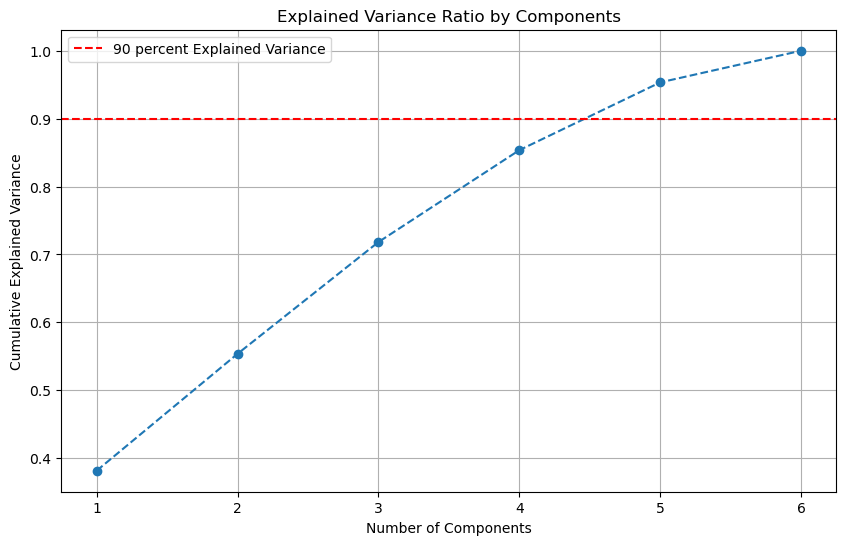

In [44]:
# Lets perform the PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=len(pca_data.columns))
pca.fit(pca_data)

# Plotting the explained variance ratio

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title("Explained Variance Ratio by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.axhline(0.90, color='red', linestyle='--', label='90 percent Explained Variance')
plt.legend()
plt.grid()
plt.show()

Since we need more than 4 components (i.e. 5 components) to capture atleast 90% of the variance in the data, the reduction is not that significant from our original 6 features. However, we will still use the PCA data because of the added benefits of reduced dimensions

In [45]:
# Now, we will make use of 90% explained variance ratio to reduce the number of components

pca = PCA(n_components=0.90)
pca.fit(pca_data)

pca_data = pca.transform(pca_data)

pca_data.shape

(9815, 5)

In [46]:
one_hot_cols = [col for col in movies_df.columns if col not in columns_to_scale]

In [47]:
# merge the pca_data with the original dataset

pca_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])
movies_df = pd.concat([movies_df[one_hot_cols], pca_df], axis=1)
movies_df.head(3)

,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,Documentary,Western,Thriller,...,Children,IMAX,Comedy,Romance,Action,PC1,PC2,PC3,PC4,PC5
0,0,0,0,0,1,1,0,0,0,0,...,1,0,1,0,0,8.672747,-2.893161,0.322203,4.369092,-0.435482
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,2.669062,-1.511226,0.093075,2.476483,-0.191862
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0.154748,-0.066092,0.735749,2.506466,-0.643795


In [48]:
# scale the data for clustering
columns_to_scale = [col for col in movies_df.columns if col.startswith("PC")]
scaler = StandardScaler()
movies_df[columns_to_scale] = scaler.fit_transform(movies_df[columns_to_scale])

movies_df.head(3)

,Horror,Mystery,War,Film-Noir,Adventure,Animation,Sci-Fi,Documentary,Western,Thriller,...,Children,IMAX,Comedy,Romance,Action,PC1,PC2,PC3,PC4,PC5
0,0,0,0,0,1,1,0,0,0,0,...,1,0,1,0,0,5.733408,-2.846504,0.324148,4.848162,-0.562674
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1.764473,-1.486855,0.093637,2.748030,-0.247900
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0.102302,-0.065026,0.740192,2.781300,-0.831830


In [49]:
movies_df.dropna(inplace=True)

---

### 2.3 Clustering.

Now that you have prepared the data, you can create the clusters.

Q: How can you determine the optimal number of clusters for your data? Please use at least two methods and provide their results.  

A: The two most common methods for choosing the number of clusters in a clustering problem are: The elbow method and the silhouette score method.  

**Elbow Method**: The elbow method is a heuristic used to determine the optimal number of clusters in a dataset. The method involves plotting the explained variation as a function of the number of clusters, and the "elbow" point is the point at which the rate of decrease sharply changes. This method is based on the principle that the optimal number of clusters is the point at which the explained variation begins to decrease at a slower rate. It uses the sum of squared distances between data points and their assigned clusters' centroids. The sum of squared distances is calculated for each number of clusters, and the optimal number of clusters is chosen based on the "elbow" point in the plot of the sum of squared distances.

To interpret the elbow method, we look for the point where the explained variation begins to decrease at a slower rate, forming an "elbow" shape in the plot. This point indicates the optimal number of clusters for the dataset.

**Silhouette Score Method**: The silhouette score is a measure of how similar an object is to its cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The silhouette score is calculated for each number of clusters, and the optimal number of clusters is chosen based on the highest silhouette score.

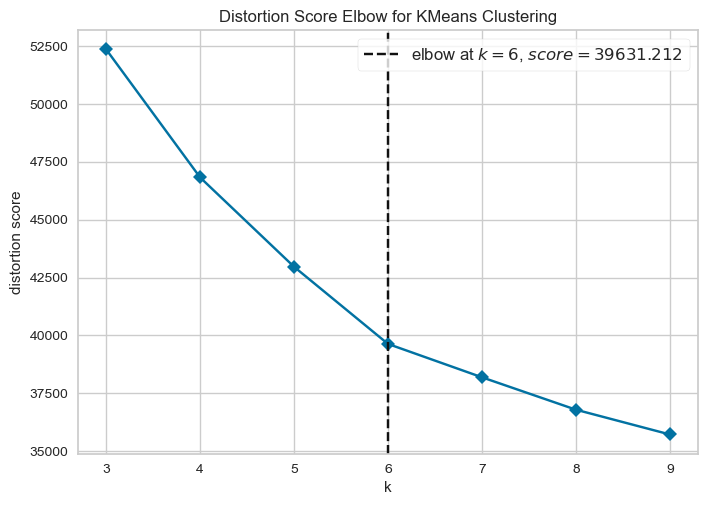

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10), timings=False)
visualizer.fit(movies_df) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

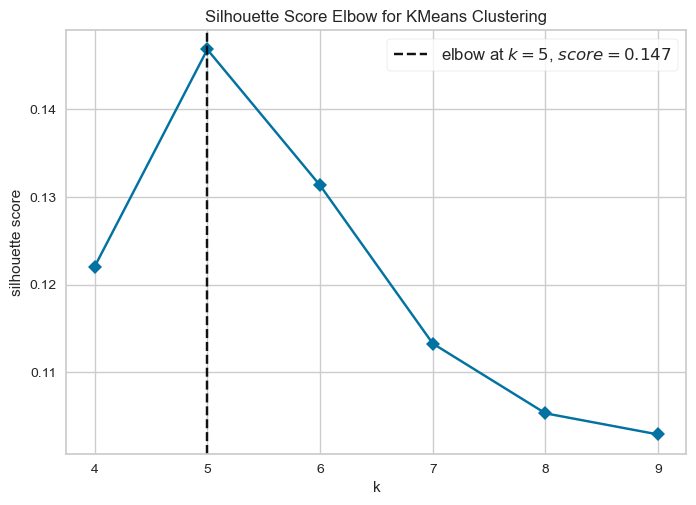

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [51]:
model = KMeans()
visualizer = KElbowVisualizer(
model, k=(4,10), metric='silhouette', timings=False)
visualizer.fit(movies_df) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figue

Both the elbow and silhouette score suggest that the optimal number of clusters is 5 or 6!

---

2. Implement the K-means clustering algorithm (not K-means++) through MapReduce. We request that you develop the algorithm from scratch based on what you've learned in class and run the algorithm on your data.

In [52]:
# Implementing KMeans from scratch using MapReduce

from pyspark import SparkContext
from pyspark.sql import SparkSession

# Initialize PySpark
sc = SparkContext.getOrCreate() # SparkContext
spark = SparkSession.builder.appName("kmeans").getOrCreate() 

# Step 0: Define parameters
k = 6  # Number of clusters
num_iterations = 10  # Maximum iterations
tolerance = 1e-4  # Convergence threshold

# Step 1: Convert DataFrame to RDD
data_rdd = sc.parallelize(movies_df.reset_index().values.tolist()) # include index for tracking

# Step 2: Initialize centroids randomly
np.random.seed(210)
initial_centroids = np.random.choice(len(movies_df), size=k, replace=False) # Randomly select k points
centroids = movies_df.iloc[initial_centroids].values # these are the initial centroids containing as values the index and the columns of the dataframe

# Step3: Define Helper functions for KMeans

# Function to compute Euclidean distance
def euclidean_distance(point, centroid):
    return np.sqrt(np.sum((np.array(point) - np.array(centroid)) ** 2))

# Function for the map step
def assign_to_centroid(row, centroids):
    """
    row: [index, feature1, feature2, ..., featureN]
    centroids: Array of current centroids
    """
    point_id = row[0]  # Extract the index
    point_features = row[1:]  # Extract the features
    distances = [euclidean_distance(point_features, centroid) for centroid in centroids]
    cluster_id = np.argmin(distances)  # Assign to nearest centroid
    return cluster_id, (point_id, point_features)  # Return the cluster ID, point ID, and features

# Step 4: Implement the KMeans algorithm by iterating over the map and reduce steps for a fixed number of iterations
# Main K-Means Loop
for iteration in range(num_iterations):
    
    # Map Phase: Assign each point to the nearest centroid. mapped is an RDD of (cluster ID, (point ID, features))
    mapped = data_rdd.map(lambda row: assign_to_centroid(row, centroids))
    
    # Reduce Phase: Compute new centroids
    clustered_points = mapped.groupByKey().mapValues(list)  # Group points by cluster ID. clustered_points is an RDD of (cluster ID, [(point ID, features)])

    # Compute new centroids as the mean of all points in the cluster
    new_centroids = (
        clustered_points.mapValues(lambda points: np.mean([point[1] for point in points], axis=0))
        .collectAsMap() # Convert to a dictionary
    )
    
    # Convert the updated centroids back to a NumPy array
    updated_centroids = np.array([new_centroids[i] for i in range(k)])

    # Check for convergence
    centroid_shift = np.linalg.norm(updated_centroids - centroids) # Compute the shift in centroids for this iteration by taking the L2 norm
    print(f"Iteration {iteration + 1}: Centroid shift = {centroid_shift:.4f}") # Print the shift in centroids
    if centroid_shift < tolerance: # Check if the shift is below the threshold
        print(f"Converged after {iteration + 1} iterations.") # Print a convergence message
        break # Exit the loop if converged

    # Update centroids for the next iteration
    centroids = updated_centroids 

 # Assign each point to the nearest centroid and collect the results - .collect() is used to convert the RDD to a list
final_clusters = data_rdd.map(lambda row: assign_to_centroid(row, centroids)).collect()

# Convert results back to a DataFrame of cluster assignments, where each row is (ClusterID, Point) with Point being (PointID, Features)
cluster_assignments = pd.DataFrame(
    final_clusters, columns=["ClusterID", "Point"]
)
cluster_assignments["PointID"] = cluster_assignments["Point"].apply(lambda x: x[0])  # Extract point ID
cluster_assignments["Features"] = cluster_assignments["Point"].apply(lambda x: x[1])  # Extract features
cluster_assignments = cluster_assignments.drop("Point", axis=1)  # Drop raw point column

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 08:43:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Iteration 1: Centroid shift = 4.7438
Iteration 2: Centroid shift = 1.5177
Iteration 3: Centroid shift = 0.8631
Iteration 4: Centroid shift = 1.1273
Iteration 5: Centroid shift = 1.0458
Iteration 6: Centroid shift = 0.4546
Iteration 7: Centroid shift = 0.2015
Iteration 8: Centroid shift = 0.1286
Iteration 9: Centroid shift = 0.1167
Iteration 10: Centroid shift = 0.1013


In [53]:
cluster_assignments.head(3)

,ClusterID,PointID,Features
0,2,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
1,2,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,4,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [54]:
cluster_assignments.groupby("ClusterID")["PointID"].apply(list)

ClusterID
0    [3.0, 36.0, 53.0, 64.0, 68.0, 76.0, 93.0, 106....
1    [7.0, 17.0, 25.0, 26.0, 27.0, 29.0, 30.0, 34.0...
2    [0.0, 1.0, 5.0, 9.0, 10.0, 15.0, 16.0, 18.0, 2...
3    [8.0, 13.0, 14.0, 23.0, 42.0, 43.0, 58.0, 73.0...
4    [2.0, 4.0, 6.0, 11.0, 37.0, 52.0, 57.0, 60.0, ...
5    [12.0, 19.0, 21.0, 22.0, 28.0, 32.0, 41.0, 44....
Name: PointID, dtype: object

#### In the output above, one can see the cluster assignments for each point in the dataset. The CluserID (as an index in the output) represents the cluster number, and the list represents the points (movies) assigned to that cluster.

3. Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.
4. Ask an LLM (ChatGPT, Claude Al, Gemini, Perplexity, etc.) to recommend another clustering algorithm. Use that LLM to describe the workings of the algorithm, as well as its advantages and disadvantages compared to K-means and K-means++. Additionally, ask to implement the algorithm for you or utilize an existing version from a package. Apply that algorithm to your data and explain any differences you observe in the results compared to those obtained previously.